_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 4

If needed, download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-04 10:40:50CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

scipy     : 1.13.0
numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.8.4
seaborn   : 0.13.2

Watermark: 2.4.3



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [ ]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

/tmp/ipykernel_8840/4012369867.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [ ]:
print(spikes.head())

     Neuron    SpikeTimes    Dir     relTime  Trial stimPeriod
514       1  15739.000000  270.0  169.000000    1.0       True
515       1  15776.566667  270.0  206.566667    1.0       True
516       1  15808.466667  270.0  238.466667    1.0       True
517       1  15821.900000  270.0  251.900000    1.0       True
518       1  15842.966667  270.0  272.966667    1.0       True


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [ ]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # add for each unique trial a subplot to the figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    neuron_spikes = spikes[spikes["Neuron"] == neuron].copy()

    n_trials = len(spikes["Trial"].unique())
    n_dirs = len(spikes["Dir"].unique())

    sorted_dirs = spikes["Dir"].unique()
    sorted_dirs.sort()

    lower_dirs = sorted_dirs[: n_dirs // 2]
    upper_dirs = sorted_dirs[n_dirs // 2 :]

    offset = (sorted_dirs[1] - sorted_dirs[0]) / n_trials

    lower_spikes = neuron_spikes[neuron_spikes["Dir"].isin(lower_dirs)]
    upper_spikes = neuron_spikes[neuron_spikes["Dir"].isin(upper_dirs)]

    lower_spikes.loc[:, "Dir"] = (
        lower_spikes["Dir"] + offset * (lower_spikes["Trial"] - 1) + offset / 2
    )
    upper_spikes.loc[:, "Dir"] = (
        upper_spikes["Dir"] + offset * (upper_spikes["Trial"] - 1) + offset / 2
    )

    ax[0].plot(
        lower_spikes["relTime"],
        lower_spikes["Dir"],
        marker="|",
        linestyle="None",
        color="black",
        markersize=4,
    )
    ax[1].plot(
        upper_spikes["relTime"],
        upper_spikes["Dir"],
        marker="|",
        linestyle="None",
        color="black",
        markersize=4,
    )

    ax[0].set_ylim(0, 180)
    ax[0].set_yticks(lower_dirs)
    ax[0].set_yticklabels(lower_dirs)
    ax[0].grid(axis="y", color="black")
    ax[0].set_ylabel("Direction [deg]")

    ax[1].set_ylim(180, 360)
    ax[1].set_yticks(upper_dirs)
    ax[1].set_yticklabels(upper_dirs)
    ax[1].grid(axis="y", color="black")

    fig.text(0.5, -0.05, "Time Relative to Stimulus Onset [ms]", ha="center")
    plt.suptitle(f"Neuron {neuron} Spike Raster")
    plt.show()

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

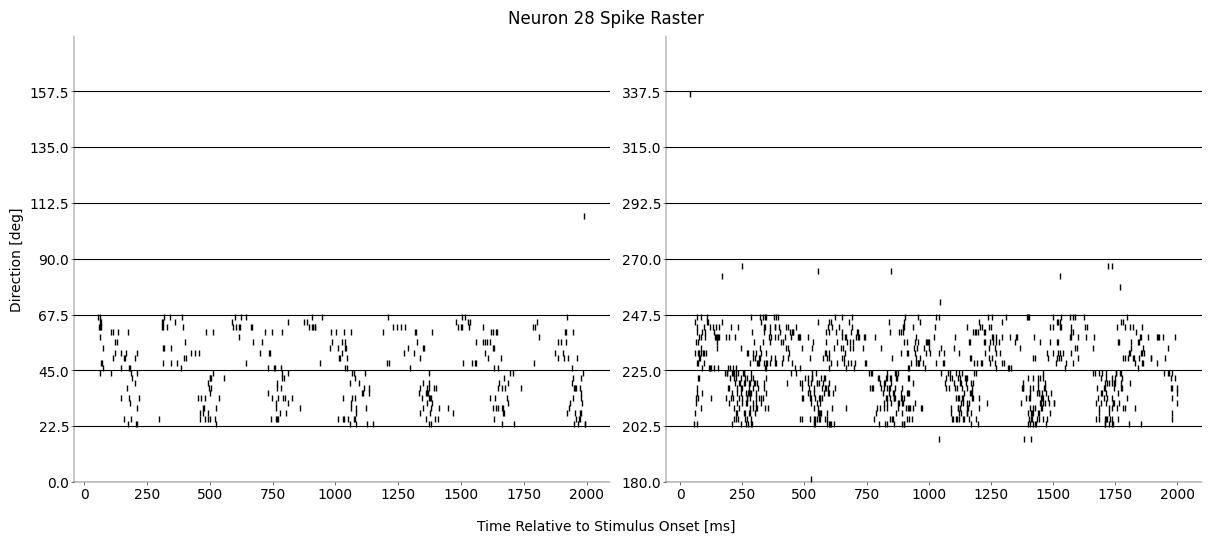

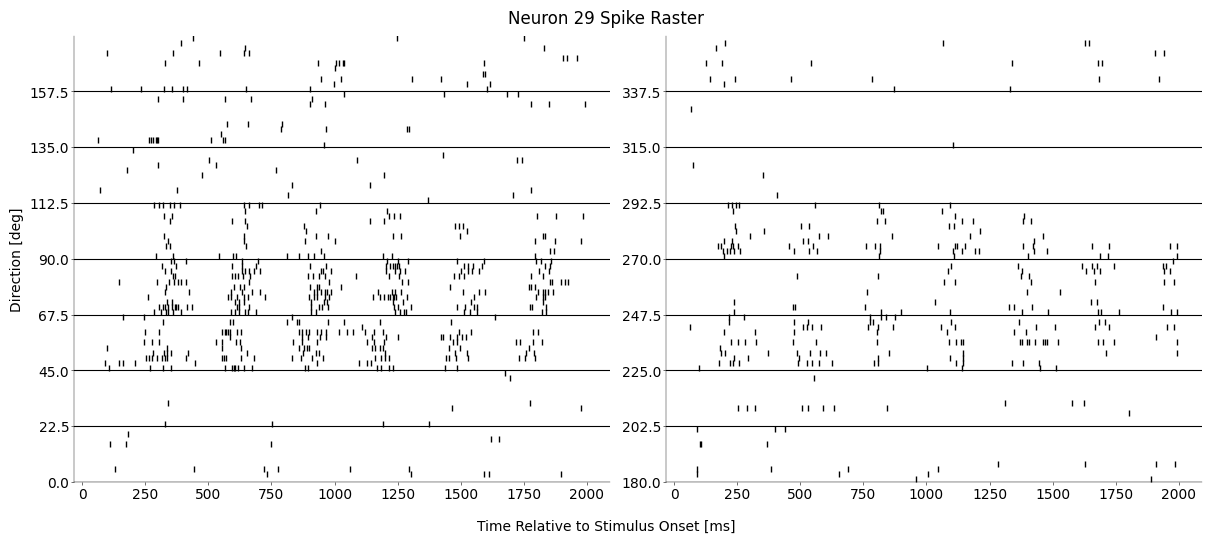

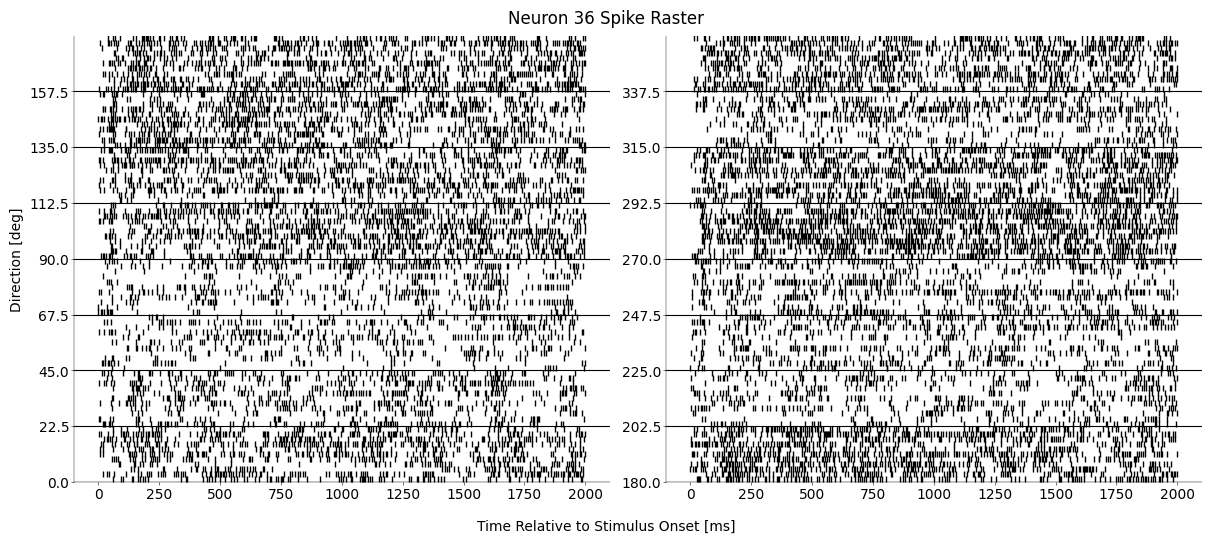

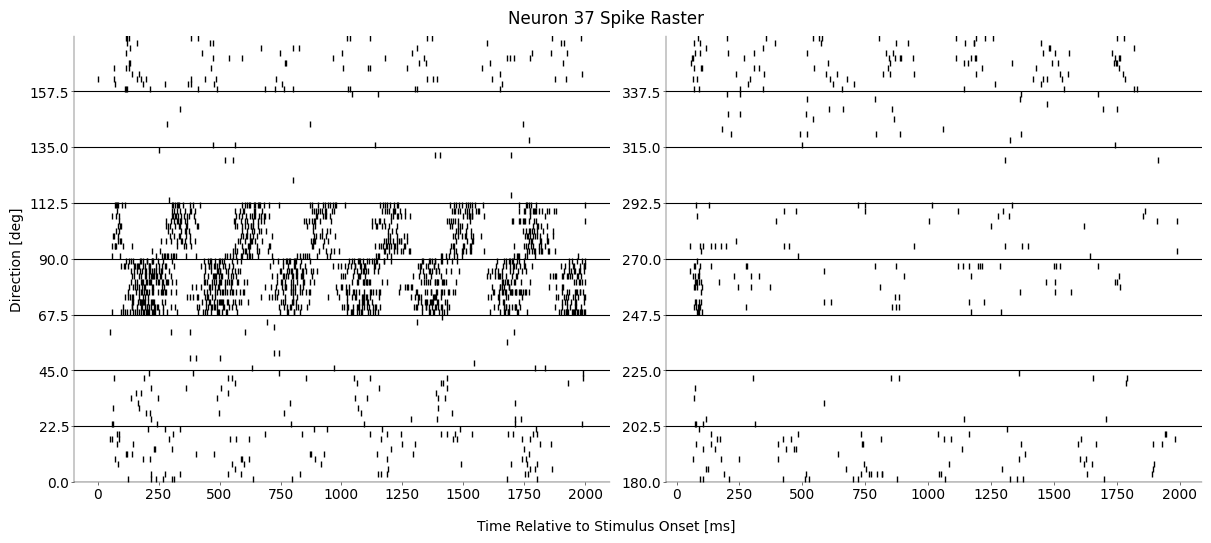

In [ ]:
plotRaster(spikes, 28)
plotRaster(spikes, 29)
plotRaster(spikes, 36)
plotRaster(spikes, 37)

We see here spike rasters corresponding to the relative stimulus onset time and the direction of the stimulus. in Neuron 37 i.e. we can clearly see that there is a spike pattern that reacts to a certain direction. The stimulus moves periodically in the direction of 70-90 degree or in the direction of 90-112 degree, both of which the neuron is selective to. Due to the selectivity of this neuron we see only spike trains during movement in the specified direction and no spikes when the stimulus moves in another direction, for instance in another trial.

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


In [ ]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # insert your code here
    bin_size = 25  # in ms

    # Filter the dataframe for the specified neuron
    neuron_spikes = spikes[spikes["Neuron"] == neuron].copy()

    # Define the time bins
    min_time = spikes["relTime"].min()
    max_time = spikes["relTime"].max()
    bins = np.arange(min_time, max_time, bin_size)

    num_trials = neuron_spikes["Trial"].nunique()

    # Create a dictionary to store the spike counts for each direction
    sorted_dirs = spikes["Dir"].unique()
    sorted_dirs.sort()
    lower_dirs = sorted_dirs[:8]
    upper_dirs = sorted_dirs[8:]
    dir_step = lower_dirs[1] - lower_dirs[0]

    # Iterate over each unique direction
    spike_counts = {}
    for dir in neuron_spikes["Dir"].unique():
        dir_spikes = neuron_spikes[neuron_spikes["Dir"] == dir].copy()

        # For each time bin, count the number of spikes and average across trials
        spike_counts[dir] = np.zeros(len(bins))
        for i, bin in enumerate(bins):
            bin_spikes = dir_spikes[
                (dir_spikes["relTime"] >= bin)
                & (dir_spikes["relTime"] < bin + bin_size)
            ]

            spike_counts[dir][i] = len(bin_spikes) / num_trials

    # Plot the PSTH
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    max_count = max([max(counts) for counts in spike_counts.values()])
    min_count = min([min(counts) for counts in spike_counts.values()])
    for dir, counts in spike_counts.items():
        # Normalize the spike counts to the range [0, 22.5] so that each direction is plotted on the same scale
        norm_counts = (counts - min_count) / (max_count - min_count) * dir_step
        axis = ax[0] if dir in lower_dirs else ax[1]
        axis.bar(
            bins,
            norm_counts,
            bottom=dir,
            width=bin_size,
            align="edge",
            color="black",
        )

    ax[0].set_ylim(0, 180)
    ax[0].set_yticks(lower_dirs)
    ax[0].set_yticklabels(lower_dirs)
    ax[0].grid(axis="y", color="black")
    ax[0].set_ylabel("Direction [deg]")

    ax[1].set_ylim(180, 360)
    ax[1].set_yticks(upper_dirs)
    ax[1].set_yticklabels(upper_dirs)
    ax[1].grid(axis="y", color="black")

    fig.text(0.5, -0.05, "Time Relative to Stimulus Onset [ms]", ha="center")
    plt.suptitle(f"Neuron {neuron} Spike Density Function")
    plt.show()

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

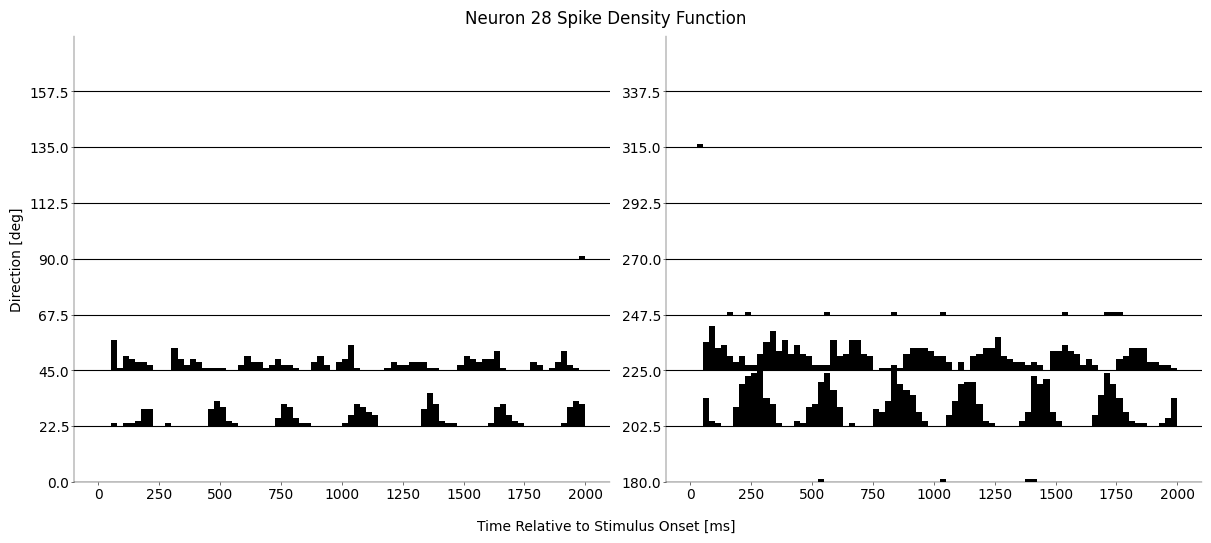

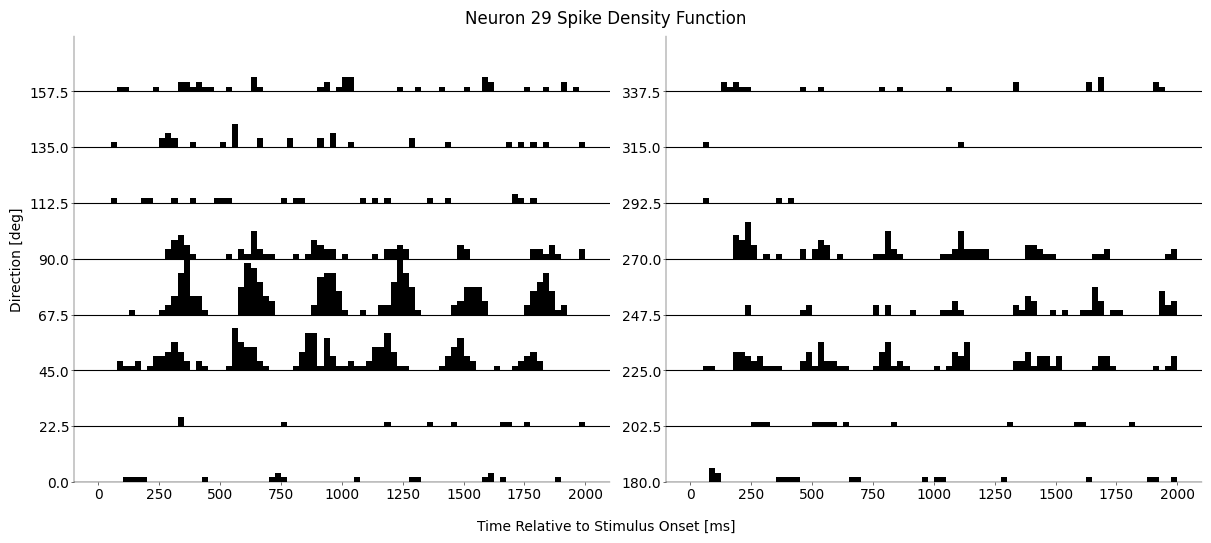

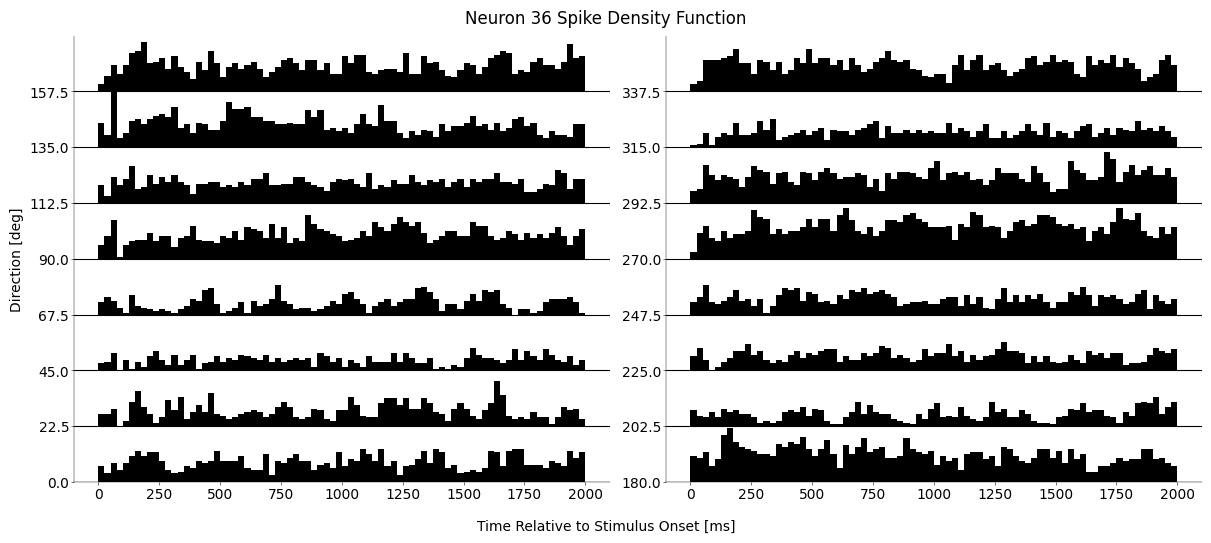

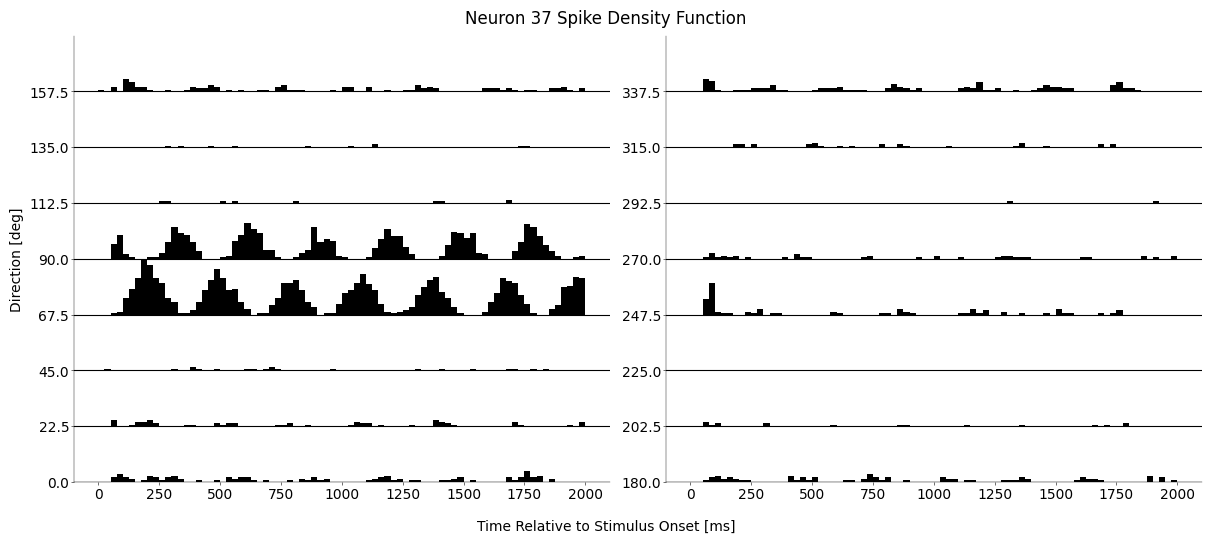

In [ ]:
plotPSTH(spikes, 28)
plotPSTH(spikes, 29)
plotPSTH(spikes, 36)
plotPSTH(spikes, 37)

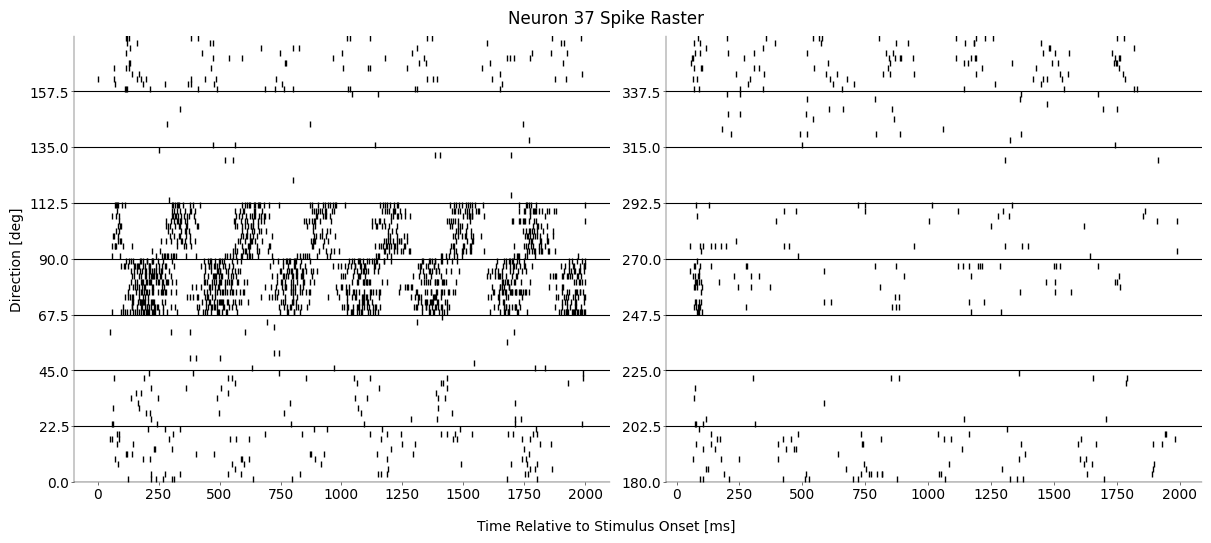

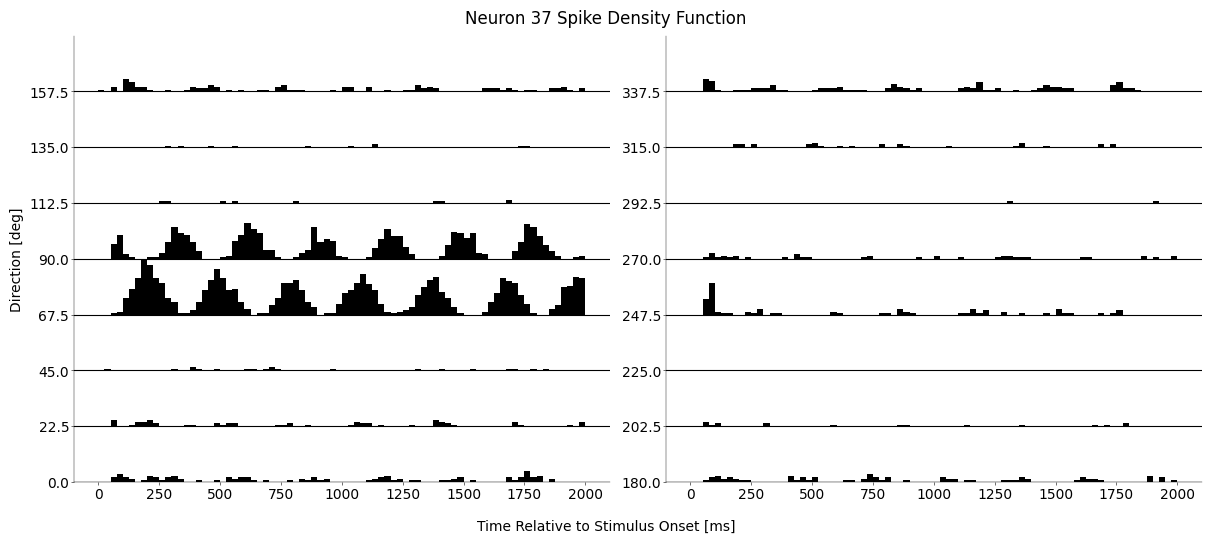

In [ ]:
# a quick comparison
plotRaster(spikes, 37)
plotPSTH(spikes, 37)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [ ]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # Convert theta to radians
    theta_rad = np.deg2rad(θ)
    phi_rad = np.deg2rad(ϕ)

    f = np.exp(
        α
        + κ * (np.cos(2 * (theta_rad - phi_rad)) - 1)
        + ν * (np.cos(theta_rad - phi_rad) - 1)
    )
    return f

Plot the von Mises function while varying the parameters systematically.

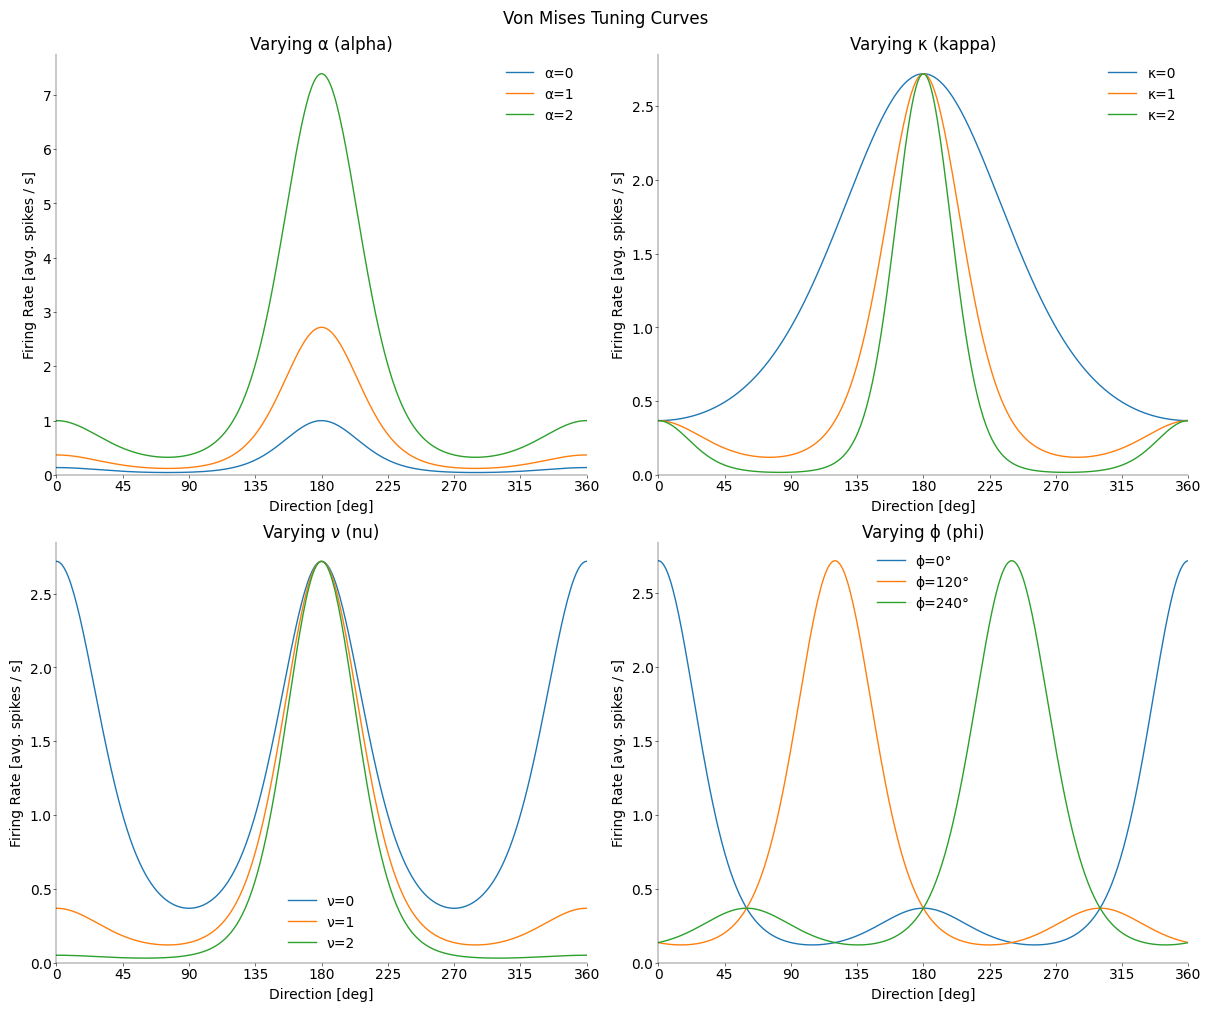

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_von_mises_curves():
    theta = np.linspace(0, 360, 360)

    # Parameter sets to vary
    alpha_values = [0, 1, 2]
    kappa_values = [0, 1, 2]
    nu_values = [0, 1, 2]
    phi_values = [
        0,
        120,
        240,
    ]

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # the plots look nicer with phi = 180 for all parameters because then the mean is centered in the center of the plot
    # Plot varying alpha
    for alpha in alpha_values:
        curve = vonMises(theta, alpha, 1, 1, 180)
        ax[0, 0].plot(theta, curve, label=f"α={alpha}")
    ax[0, 0].set_title("Varying α (alpha)")
    ax[0, 0].legend()

    # Plot varying kappa
    for kappa in kappa_values:
        curve = vonMises(theta, 1, kappa, 1, 180)
        ax[0, 1].plot(theta, curve, label=f"κ={kappa}")
    ax[0, 1].set_title("Varying κ (kappa)")
    ax[0, 1].legend()

    # Plot varying nu
    for nu in nu_values:
        curve = vonMises(theta, 1, 1, nu, 180)
        ax[1, 0].plot(theta, curve, label=f"ν={nu}")
    ax[1, 0].set_title("Varying ν (nu)")
    ax[1, 0].legend()

    # Plot varying phi
    for phi in phi_values:
        curve = vonMises(theta, 1, 1, 1, phi)
        ax[1, 1].plot(theta, curve, label=f"ϕ={phi}°")
    ax[1, 1].set_title("Varying ϕ (phi)")
    ax[1, 1].legend()

    for a in ax.flatten():
        a.set_xticks(np.arange(0, 361, 45))
        a.set_xlabel("Direction [deg]")
        a.set_ylabel("Firing Rate [avg. spikes / s]")
        a.set_xlim(0, 360)
        a.set_ylim(bottom=0)

    plt.suptitle("Von Mises Tuning Curves")
    plt.show()


# Run the function to plot the curves
plot_von_mises_curves()

### Explanation of the parameters:
von Mises Model implements a mixture of sensitivity of the neuron to orientiation and direction of the movement. This is shown via the parameters as the implied firing rate (spikes/sec) can be modeled selectively for orientation and direction by fine tuning the parameters of the von Mises model.

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

$ \alpha , \kappa $ and $\nu $ make it possible to vary the curve such that peaks of varying size and amplitude for a certain direction of movement are possible.

$\alpha$: Varies the amplitude of the response. Higher $\alpha$ results in a higher amplitude. It doesn't alter the shape of the curve. Essentially just scales the curve.

$\kappa$: Controls the amplitude and influence for the second harmonic. Varies the sharpness / steepness of the curvature around $\phi$. The higher $\kappa$, the more pronounced the curve around the value of $\phi$ is, meaning the response is more concentrated around $\phi$. A higher $\kappa$ also makes the influence of the second harmonic more pronounced.

$\nu$: Controls the amplitude and influence for the first harmonic. As $\nu$ increases, the concentration of the response around $\phi$ becomes higher. Also shows the influence of the first harmonic: when $\nu$ = 0 we see the second harmonic "taking over". With a higher $\nu$, the influence of the second harmonic becomes lower (relatively) and that of the first becomes higher.

$ \phi $: phaseshifts the mean / peak of the firing rate, making it possible to shift the peak to the correct position. Is essentially the mean around which the data is centered.


In [ ]:
from scipy.optimize import curve_fit


def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, show: bool = True, neuron: int = 1
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.

    neuron: int, default=1
        id of the plotted neuron (we added this for a nicer plot)

    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # Initial guess for the parameters
    initial_guess = [np.mean(counts), 1, 1, np.median(dirs)]

    # Perform the non-linear least squares fit
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, 360])
    popt, _ = curve_fit(
        vonMises, dirs, counts, p0=initial_guess, bounds=bounds, maxfev=5000
    )

    if show:
        # Plot the data and fitted tuning curve
        fig, ax = plt.subplots(figsize=(7, 5))

        # Plot individual trial data
        ax.scatter(dirs, counts, label="Individual Trials", color="blue", s=15)

        # Plot average spike count per direction
        unique_dirs = np.unique(dirs)
        mean_counts = [np.mean(counts[dirs == d]) for d in unique_dirs]
        ax.plot(
            unique_dirs,
            mean_counts,
            label="Mean Spike Count",
            color="orange",
            linewidth=2,
            alpha=0.7,
        )

        # Plot fitted tuning curve
        fitted_curve = vonMises(unique_dirs, *popt)
        ax.plot(
            unique_dirs,
            fitted_curve,
            label="Fitted von Mises Curve",
            color="red",
            linestyle="--",
        )

        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xlim(0, 360)
        ax.set_xlabel("Direction [deg]")
        ax.set_ylabel("Spike Count")
        ax.set_title("Tuning Curve Fit of Neuron {}".format(neuron))
        ax.legend()
        plt.show()

    return popt

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [ ]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

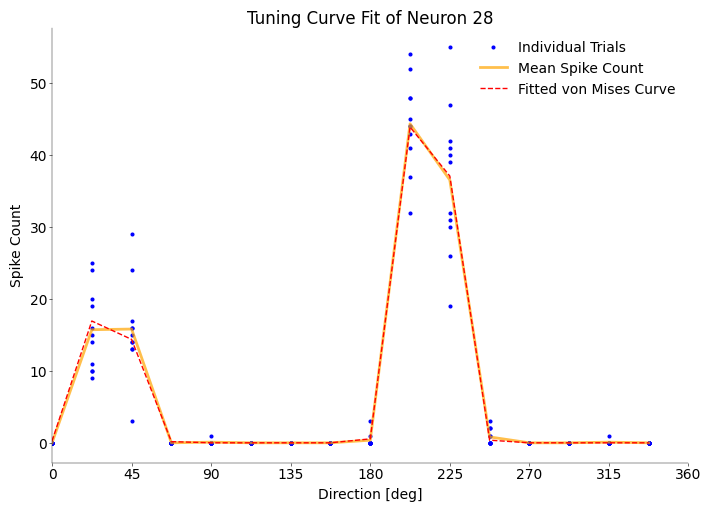

In [ ]:
dirs, counts = get_data(spikes, 28)
# add plot
p = tuningCurve(counts, dirs, neuron=28)

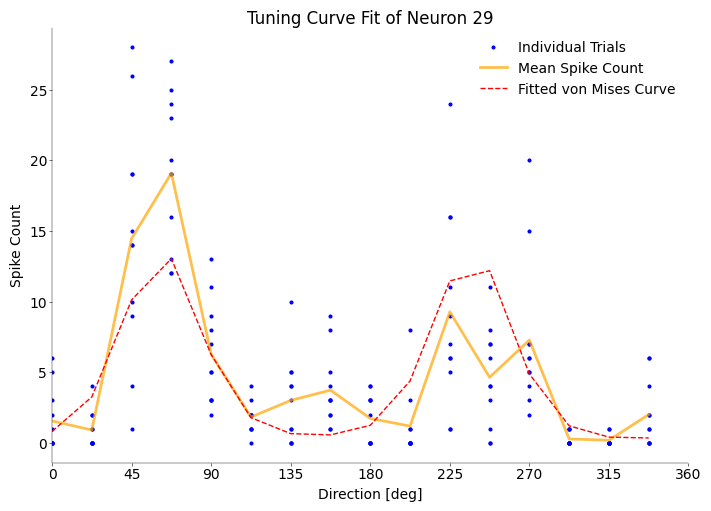

In [ ]:
dirs, counts = get_data(spikes, 29)
# add plot
p = tuningCurve(counts, dirs, neuron=29)

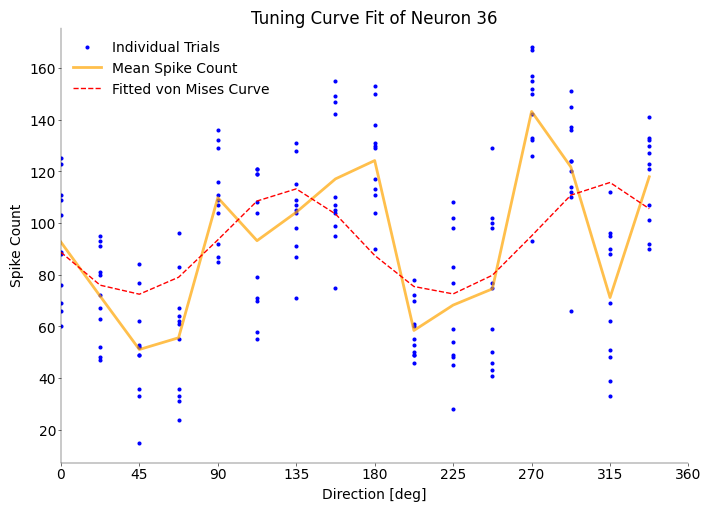

In [ ]:
dirs, counts = get_data(spikes, 36)
# add plot
p = tuningCurve(counts, dirs, neuron=36)

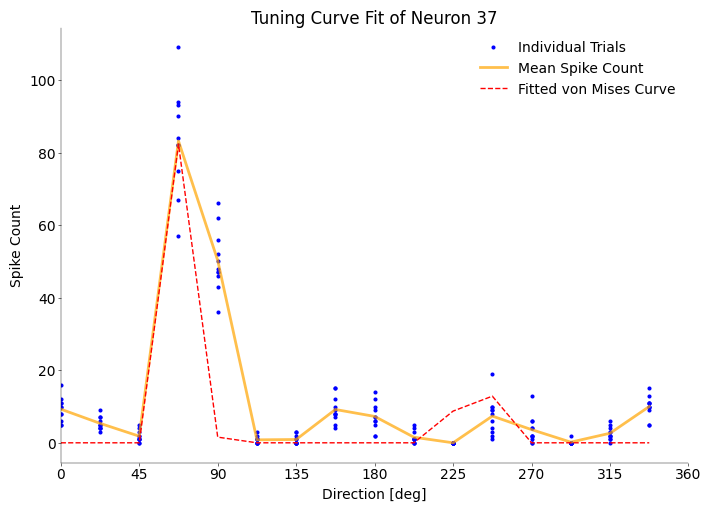

In [ ]:
dirs, counts = get_data(spikes, 37)
# add plot
p = tuningCurve(counts, dirs, neuron=37)

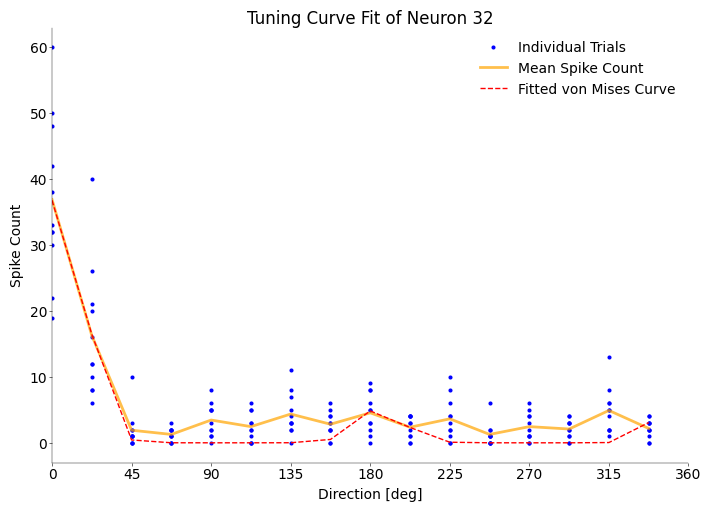

In [ ]:
dirs, counts = get_data(spikes, 32)
# add plot
p = tuningCurve(counts, dirs, neuron=32)

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
    neuron: int = 1,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    neuron: int, default=1
        id of the plotted neuron (we added this for a nicer plot)

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # Convert directions to radians
    theta_k = np.deg2rad(np.unique(dirs))
    unique_dirs = np.unique(dirs)
    m_k = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])
    v_k = np.exp(psi * 1j * theta_k)
    q = np.abs(np.dot(m_k, v_k))

    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)

    for i in range(niters):
        shuffled_counts = rng.permutation(counts)
        shuffled_m_k = np.array(
            [np.mean(shuffled_counts[dirs == d]) for d in unique_dirs]
        )
        qdistr[i] = np.abs(np.dot(shuffled_m_k, v_k))

    p = np.sum(qdistr >= q) / niters

    if show:
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(qdistr, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_title(
            "Permutation Test for Direction Tuning of Neuron {}".format(neuron)
        )
        ax.set_xlim(left=0)
        ax.legend()
        plt.show()

    return p, q, qdistr

Show null distribution for the example cell:

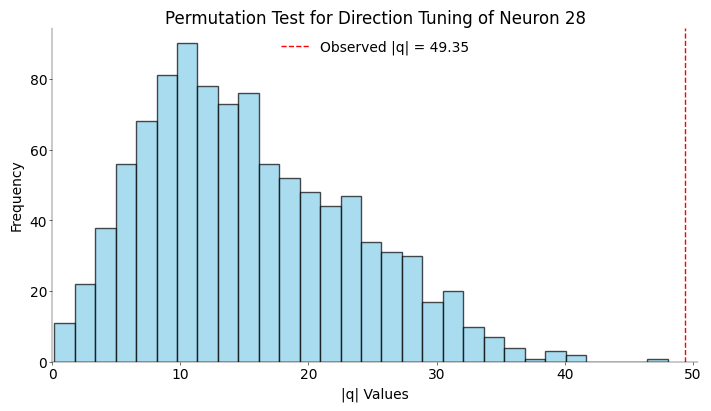

In [ ]:
# ------------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (0.5 pts)
# ------------------------------------------------------------

dirs, counts = get_data(spikes, 28)
# add plot
p, q, qdistr = testTuning(counts, dirs, show=True, neuron=28)

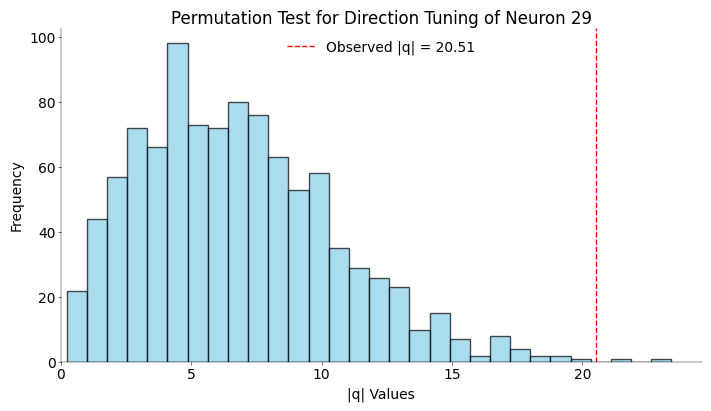

In [ ]:
dirs, counts = get_data(spikes, 29)
# add plot
p, q, qdistr = testTuning(counts, dirs, show=True, neuron=29)

Test all cells for orientation and direction tuning

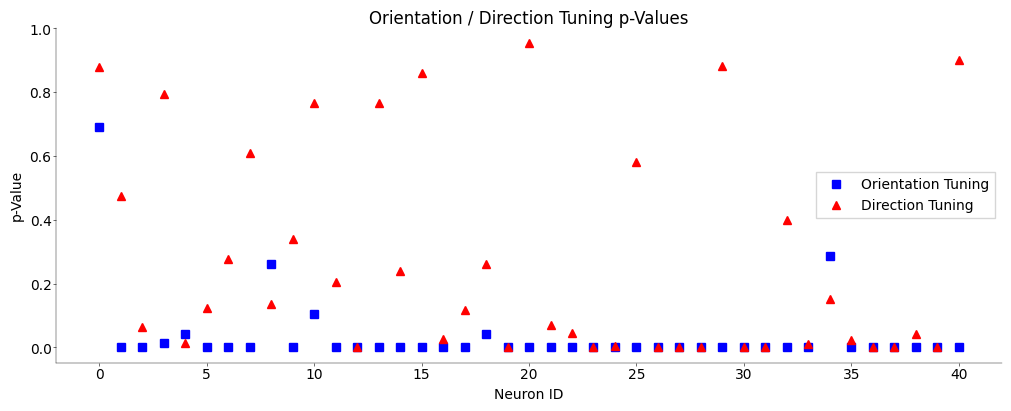

In [ ]:
# -------------------------------------------------------
# Test cells for orientation / direction tuning (0.5 pts)
# -------------------------------------------------------

# collect p values for orientation / direction selectivity
# orientation sensitivity is psi = 1
neurons = spikes["Neuron"].unique()
p_orientation = np.zeros(len(neurons))
p_direction = np.zeros(len(neurons))
for neuron in spikes["Neuron"].unique():
    dirs, counts = get_data(spikes, neuron)
    p, q, qdistr = testTuning(counts, dirs, psi=2, show=False)
    p_orientation[neuron - 1] = p

# direction sensitivity is psi = 1
for neuron in spikes["Neuron"].unique():
    dirs, counts = get_data(spikes, neuron)
    p, q, qdistr = testTuning(counts, dirs, psi=1, show=False)
    p_direction[neuron - 1] = p

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    p_orientation, marker="s", linestyle="None", label="Orientation Tuning", color="b"
)  # Square marker, blue color
ax.plot(
    p_direction, marker="^", linestyle="None", label="Direction Tuning", color="r"
)  # Triangle marker, red color
ax.set_xlabel("Neuron ID")
ax.set_ylabel("p-Value")
ax.set_title("Orientation / Direction Tuning p-Values")
ax.legend(frameon=True)
plt.show()

Number of direction tuned neurons:

In [ ]:
# count cells with p < 0.01 (which ones are they?)
n_direction_tuned = np.sum(p_direction <= 0.01)
print(f"Number of direction tuned neurons: {n_direction_tuned}")
print(f"Neurons: {np.where(p_direction <= 0.01)[0].tolist()}")

Number of direction tuned neurons: 13
Neurons: [12, 19, 23, 24, 26, 27, 28, 30, 31, 33, 36, 37, 39]


Number of orientation tuned neurons:

In [ ]:
# count cells with p < 0.01 (which ones are they?)
n_orientation_tuned = np.sum(p_orientation <= 0.01)
print(f"Number of orientation tuned neurons: {n_orientation_tuned}")
print(f"Neurons: {np.where(p_orientation <= 0.01)[0].tolist()}")

Number of orientation tuned neurons: 34
Neurons: [1, 2, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40]
